<div style="text-align: center;font-weight:bold; font-size:300%; LINE-HEIGHT:125%">
    <br>Deep Learning ECE 614<br>
</div>
<div style="text-align: center;font-weight:bold; font-size:200%; LINE-HEIGHT:125%"> 
        Laboratory #4<br>
        Spring 2020<br> 
        Classification of MNIST Digits with Convolutional Neural Networks (CNN)<br>
</div>
<div style="text-align: center; font-size:100%"> 
        <br><b>Objective:</b> To understand and implement a classification of 2D images with convolutional neural networks.
</div>


## Tasks
1. Run the code as given. Do this cell by cell by clicking the Run button in the tool bar above. All cells can be run by a command in the "Cell" drop down menu. Note the number of parameters in this network compared to Lab #2.
2. In the visualization code segment, add an additional plot for the accuracy of the model vs training epoch.
3. Experiment with changing hyperparameters such as: convolutional kernel size, number of kernels, depth of network (number of layers), number of epochs. Compare results with others in this lab. Comment on accuracy of this LAB classification results as compared to earlier LABs.


## Imports
This lab will use the numpy for general and matrix mathematical functions, matplotlib for visualization, and  Keras for AI algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K

Using TensorFlow backend.


## Data Loading and Reshaping
Keras provides the MNIST dataset from here: https://keras.io/datasets/, more info here http://yann.lecun.com/exdb/mnist/

Keras models expect inputs to be tensors, represented as multidimensional arrays. The data should be formatted such that each sample is a row (index in the first dimension) of the array. The MNIST dataset is natively in the form of an M x W x H array, where M is the number of samples, W is the width of each image, and H is the height of each image. This is almost correct for the convolutional layers that will be used in this lab. However, they expect a fourth order tensor in the form of M x W x H x C, where C is the number of color channels in the image and the other dimensions are as before. For a standard RGB image this dimension would be size 3. The C dimension is still required even if the image is grayscale (one color channel). Information on the function used to perform this change can be found here: https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html#numpy.reshape

The output data must also be vectorized. By default each class label is an integer between 0-9. For training, a target vector of length equal to the number of classes with a 1 in the correct class index is required. Keras has built in utilities to do this conversion. Observe the output below for the first nine samples in the MNIST dataset https://keras.io/utils/#to_categorical

11493376/11490434 [==============================] - 0s 0us/step


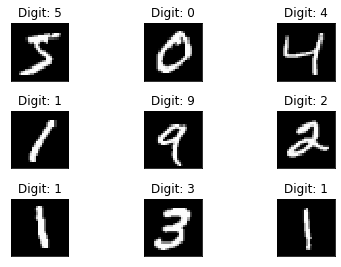

y data before: 
[5 0 4 1 9]

y data after:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()
    
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train/255
x_test = x_test/255

num_classes = 10
print('y data before: ')
print(y_train[0:5])

y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)
print('\ny data after:')
print(y_train[0:5])


## Model Setup
![classification%20cnn.png]See Fig. Model, separate(attachment:classification%20cnn.png)
For this laboratory the loss, output layer, and metrics will be the same as in Laboratory 2, Classification with MLPs. The biggest change will be in the architecture of the model now using convolutional layers to extract image features.

Previously when preparing the data for use with MLPs, the images were reshaped (dimensionality changed) into vectors. By doing this, explicit adjacency information or planar features or correlations were lost. The convolutional layers keep and utilize this information, learning context around each pixel.

Keras has the capabililty for convolutional layers in 1D, 2D, or 3D. Since the input data are planar patterns (2D images), 2D convolutions will be used. 1D convolutions can be used for 1D signal analysis applications such as audio, text, etc. 3D convolutions are heavily used in medical image (MRI, CT, etc.) analysis. As a side note, most deep learning packages actually do correlation instead of convolution, but the difference is only transposing the kernel, so no practical difference in this application.

Adding a convolutional layer is similar to a Dense layer, the first argument is the number of unique kernels for this layer. The second required argument is the size of the kernel. This is generally a tuple of odd numbered integers ((n, n) for 2D convolution). This lab starts with 5x5 and 3x3 kernels respectively. https://keras.io/layers/convolutional/#conv2d

Another layer introduced here is the MaxPooling layer. This layer is used to downsample the image by just taking the maximum value in a neighborhood of pixels. The first argument to the layer is the size of this neighborhood. By default the operation is strided by the same value. Meaning a 2x2 neighborhood will result in a half sized output. https://keras.io/layers/pooling/#maxpooling2d

The final new layer is the Flatten Layer. It reduces the dimensionality of the previous layers output to a vector. https://keras.io/layers/core/#flatten
The concept behind this is that the convolutional layers will extract abstract features from the images, such as edges, shapes, or complex features like eyes and faces. Then a MLP network is used to separate these high level features into their respective classes. 

As before in Lab #2, Cross Entropy (CE) will be used as loss, and the accuracy metric will be used to judge the percentage of correct predictions from the network.
$$CE = -\sum_{i}^C t_i\ln{s_i}  $$

$$\DeclareMathOperator*{\argmax}{arg\,max} Acc = \frac{1}{M}\sum_{k}^M\argmax{t_k} == \argmax{s_k} $$

In [3]:
K.clear_session()
model = Sequential()
model.add(Conv2D(8, (9,9), activation='relu', input_shape=(28,28,1,)))
model.add(MaxPooling2D((2,2), name='pool_1'))
model.add(Conv2D(16, (5,5), activation='relu'))
model.add(MaxPooling2D((2,2), name='pool_2'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 8)         656       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          3216      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2320      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

## Model Training
The first two arguments of the fit function are the input and target data, followed by the number of epochs, and the batch size. The optional 'verbose' argument can be used to turn off the output text. Many of the other options are available and will be used in future laboratories. This example also uses validation data from the MNIST test set. The loss and metrics will be calculated for this data, however they are not used to directly adjust weights.


To start, training will be performed for 10 epochs with a batch size of 128, on 10,000 of the training images. 1,000 of the test images will be used for validation. This reduced dataset is to increase training speed. If time permits, try training/testing on the full dataset.

Options for compiling, fitting, and evaluating the model can be found here.
https://keras.io/models/model/

In [0]:
training_samples = 60000
testing_samples  = 10000

batch_size = 128
epochs     = 25

history = model.fit(x_train[:training_samples],
                    y_train[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test[:testing_samples],y_test[:testing_samples]))

Epoch 1/25
469/469 [==============================] - 24s 51ms/step - loss: 0.5223 - accuracy: 0.8356 - val_loss: 0.1486 - val_accuracy: 0.9551
Epoch 2/25
469/469 [==============================] - 24s 51ms/step - loss: 0.1357 - accuracy: 0.9596 - val_loss: 0.1101 - val_accuracy: 0.9631
Epoch 3/25
469/469 [==============================] - 23s 50ms/step - loss: 0.0985 - accuracy: 0.9701 - val_loss: 0.0762 - val_accuracy: 0.9761
Epoch 4/25
469/469 [==============================] - 23s 50ms/step - loss: 0.0813 - accuracy: 0.9756 - val_loss: 0.0696 - val_accuracy: 0.9795
Epoch 5/25
469/469 [==============================] - 24s 51ms/step - loss: 0.0723 - accuracy: 0.9778 - val_loss: 0.0606 - val_accuracy: 0.9819
Epoch 6/25
469/469 [==============================] - 24s 51ms/step - loss: 0.0639 - accuracy: 0.9803 - val_loss: 0.0547 - val_accuracy: 0.9831
Epoch 7/25
469/469 [==============================] - 24s 50ms/step - loss: 0.0583 - accuracy: 0.9816 - val_loss: 0.0491 - val_accuracy:

## Visualization
The %matplotlib qt will make a new, interactive window. Change the qt to inline for figures to appear in this window, but they will not be interactive.

The below code segment outputs two plots from the training performed in the previous code segment. These show the average loss across the training and validation datasets for each epoch. Using the same 'history' object add an additional plot for the average training and validation accuracy metric across each epoch.

In [0]:
%matplotlib inline

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend(('train','validation'))

#### Students to add accuracy plot here ####

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.title.set_text('Model Accuracy')
plt.ylabel('Accuracy'); plt.xlabel('epoch')
ax1.legend(('train','validation'))

plt.show()

## Feature Maps

Using the Functional model building in Keras, new models are built using intermediate layers from the trained model. A sample set of these outputs is generated by the code below from these layers for visualization of features.

In [0]:
low_level_layer = Model(inputs=model.input,
                        outputs=model.layers[0].output)
print(low_level_layer)
high_level_layer = Model(inputs=model.input,
                         outputs = model.layers[2].output)

In [0]:
sample_set = 6

low_level_features = low_level_layer.predict(x_train[:sample_set])
high_level_features = high_level_layer.predict(x_train[:sample_set])

for sample in range(sample_set):
    plt.figure()
    plt.imshow(x_train[sample][:,:,0])
    fig = plt.figure(figsize=[12.8,3])
    for i in range(8):
        
        feature_map = low_level_features[sample, :, :, i]

        plt.subplot(2, 8, i+1)
        plt.imshow(feature_map, interpolation='none')
        plt.axis('off')
    for i in range(8):

        feature_map = high_level_features[sample, :, :, i]

        plt.subplot(2, 8, i+9)
        plt.imshow(feature_map, interpolation='none')
        plt.axis('off')

        

## Appendix A - Log Loss

In [0]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1e-6,2, 100)

fig = plt.figure(figsize=[10,5])
plt.plot(x,-np.log(x))
plt.grid(True)
plt.title('Log loss (Cross Entropy)')
plt.xlabel('x')
plt.ylabel('-ln(x)')
plt.show()

## Appendix B - Activation Functions

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.activations import relu, tanh, sigmoid, hard_sigmoid 
from keras.backend import eval

x = np.linspace(-5,5,100)

fig = plt.figure(figsize=[20,4.8])
plt.subplot(1,3,1)
plt.plot(x, eval(sigmoid(x)))
plt.ylabel('Sigmoid')
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(x, eval(tanh(x)))
plt.ylabel('tanh')
plt.grid(True)
plt.title('Example Activation Functions')

plt.subplot(1,3,3)
plt.plot(x, eval(relu(x)))
plt.ylabel('ReLU')
plt.grid(True)

plt.show()

$$\textrm{Sigmoid}(x) = \frac{1}{1+e^{-x}}$$


$$\textrm{tanh}(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^x-e^{-x}}{e^x+e^{-x}}$$


$$\textrm{ReLU}(x) = \max(0,x)$$